In [41]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the dataset
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

## Data Cleaning

In [3]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Ensure correct data types
df['Year'] = df['Year'].astype(int)
df['Country'] = df['Country'].astype(str)
df['Region'] = df['Region'].astype(str)

Missing values in each column:
Country                        0
Region                         0
Year                           0
Infant_deaths                  0
Under_five_deaths              0
Adult_mortality                0
Alcohol_consumption            0
Hepatitis_B                    0
Measles                        0
BMI                            0
Polio                          0
Diphtheria                     0
Incidents_HIV                  0
GDP_per_capita                 0
Population_mln                 0
Thinness_ten_nineteen_years    0
Thinness_five_nine_years       0
Schooling                      0
Economy_status_Developed       0
Economy_status_Developing      0
Life_expectancy                0
dtype: int64


## Feature Engineering

In [4]:
# Combine 'Economy_status_Developed' and 'Economy_status_Developing' into a single variable
def economic_status(row):
    if row['Economy_status_Developed'] == 1:
        return 'Developed'
    else:
        return 'Developing'

df['Economic_Status'] = df.apply(economic_status, axis=1)

# Drop the original economy status columns
df.drop(['Economy_status_Developed', 'Economy_status_Developing'], axis=1, inplace=True)

# Create an average immunization score
df['Avg_Immunization'] = df[['Hepatitis_B', 'Measles', 'Polio', 'Diphtheria']].mean(axis=1)

# Create mortality ratio
df['Adult_to_Infant_Mortality_Ratio'] = df['Adult_mortality'] / (df['Infant_deaths'] + 1)

# Log transformation of GDP per capita
df['GDP_per_capita_log'] = np.log(df['GDP_per_capita'] + 1)

# Combine thinness variables
df['Thinness_children_adolescents'] = df[['Thinness_ten_nineteen_years', 'Thinness_five_nine_years']].mean(axis=1)

# Combine infant and under-five deaths
df['Child_deaths'] = df['Infant_deaths'] + df['Under_five_deaths']

## Handling Multicollinearity

In [5]:
#  Drop individual immunization variables since we have 'Avg_Immunization'
df.drop(['Hepatitis_B', 'Measles', 'Polio', 'Diphtheria'], axis=1, inplace=True)

# Drop 'GDP_per_capita' since we have 'GDP_per_capita_log'
df.drop('GDP_per_capita', axis=1, inplace=True)

# Drop original thinness variables
df.drop(['Thinness_ten_nineteen_years', 'Thinness_five_nine_years'], axis=1, inplace=True)

# Drop original child mortality variables
df.drop(['Infant_deaths', 'Under_five_deaths'], axis=1, inplace=True)

# Address dummy variable trap for 'Economic_Status'
# Since we have 'Economic_Status' as a categorical variable, we need to encode it
df = pd.get_dummies(df, columns=['Economic_Status'], drop_first=True)

## Recalculating VIFs

In [6]:
# Prepare the list of features for VIF calculation
# Exclude target variable 'Life_expectancy' and non-numeric columns
features = df.select_dtypes(include=[np.number]).columns.tolist()
features.remove('Life_expectancy')  # Remove target variable

# Prepare the data for VIF calculation
X = df[features]

# Recalculate VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("\nVIF values after adjustments:")
print(vif_data)


VIF values after adjustments:
                            feature         VIF
0                              Year  637.956691
1                   Adult_mortality   33.011965
2               Alcohol_consumption    6.165329
3                               BMI  345.813364
4                     Incidents_HIV    3.576713
5                    Population_mln    1.233581
6                         Schooling   29.347541
7                  Avg_Immunization   83.525004
8   Adult_to_Infant_Mortality_Ratio   11.626122
9                GDP_per_capita_log  150.249350
10    Thinness_children_adolescents    4.502696
11                     Child_deaths   16.875534


In [7]:
# Save the cleaned and prepared dataset
df.to_csv('Cleaned_Life_Expectancy_Data.csv', index=False)

print("\nData cleaning and feature engineering complete. Cleaned data saved to 'Cleaned_Life_Expectancy_Data.csv'.")


Data cleaning and feature engineering complete. Cleaned data saved to 'Cleaned_Life_Expectancy_Data.csv'.


## Visualizations

In [8]:
df = pd.read_csv('Cleaned_Life_Expectancy_Data.csv')
print(df.describe())

              Year  Adult_mortality  Alcohol_consumption          BMI  \
count  2864.000000      2864.000000          2864.000000  2864.000000   
mean   2007.500000       192.251775             4.820882    25.032926   
std       4.610577       114.910281             3.981949     2.193905   
min    2000.000000        49.384000             0.000000    19.800000   
25%    2003.750000       106.910250             1.200000    23.200000   
50%    2007.500000       163.841500             4.020000    25.500000   
75%    2011.250000       246.791375             7.777500    26.400000   
max    2015.000000       719.360500            17.870000    32.100000   

       Incidents_HIV  Population_mln    Schooling  Life_expectancy  \
count    2864.000000     2864.000000  2864.000000      2864.000000   
mean        0.894288       36.675915     7.632123        68.856075   
std         2.381389      136.485867     3.171556         9.405608   
min         0.010000        0.080000     1.100000        39.40

c:\Users\sabme\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


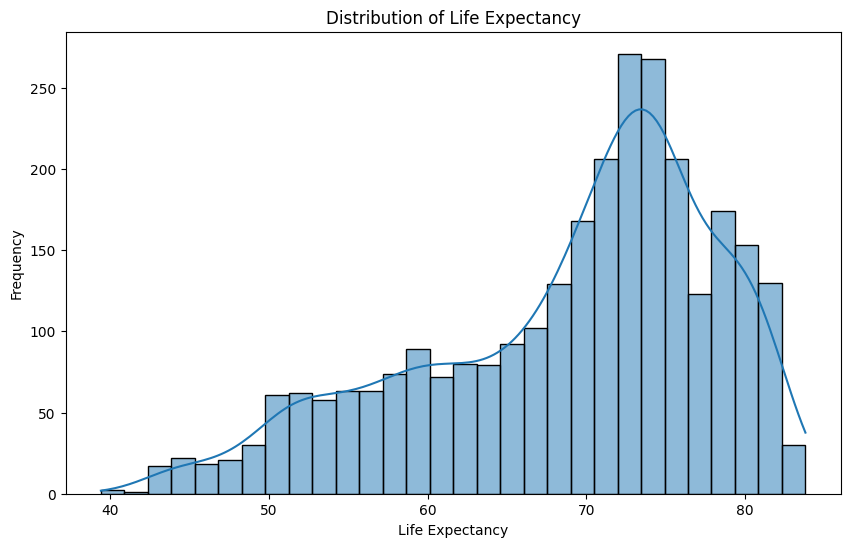

In [9]:
plt.figure(figsize=(10,6))
sns.histplot(df['Life_expectancy'], bins=30, kde=True)
plt.title('Distribution of Life Expectancy')
plt.xlabel('Life Expectancy')
plt.ylabel('Frequency')
plt.show()

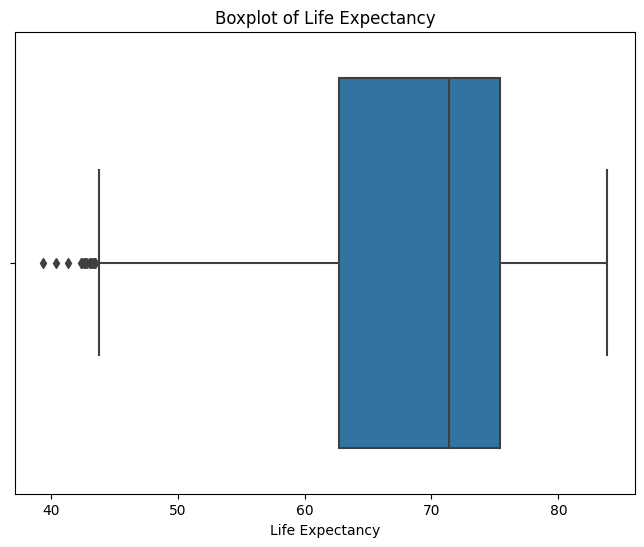

In [10]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df['Life_expectancy'])
plt.title('Boxplot of Life Expectancy')
plt.xlabel('Life Expectancy')
plt.show()

C:\Users\sabme\AppData\Local\Temp\ipykernel_40440\2772263935.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='Year', y='Life_expectancy', ci=None)
c:\Users\sabme\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sabme\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


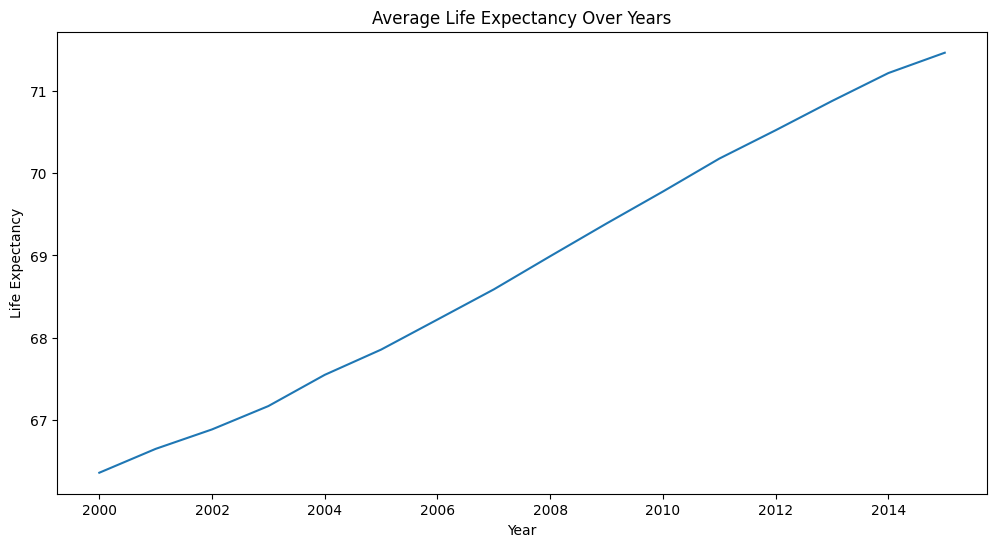

In [11]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Year', y='Life_expectancy', ci=None)
plt.title('Average Life Expectancy Over Years')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.show()

C:\Users\sabme\AppData\Local\Temp\ipykernel_40440\1047834229.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='Year', y='Life_expectancy', hue='Economic_Status_Developing', ci=None)
c:\Users\sabme\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sabme\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sabme\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pa

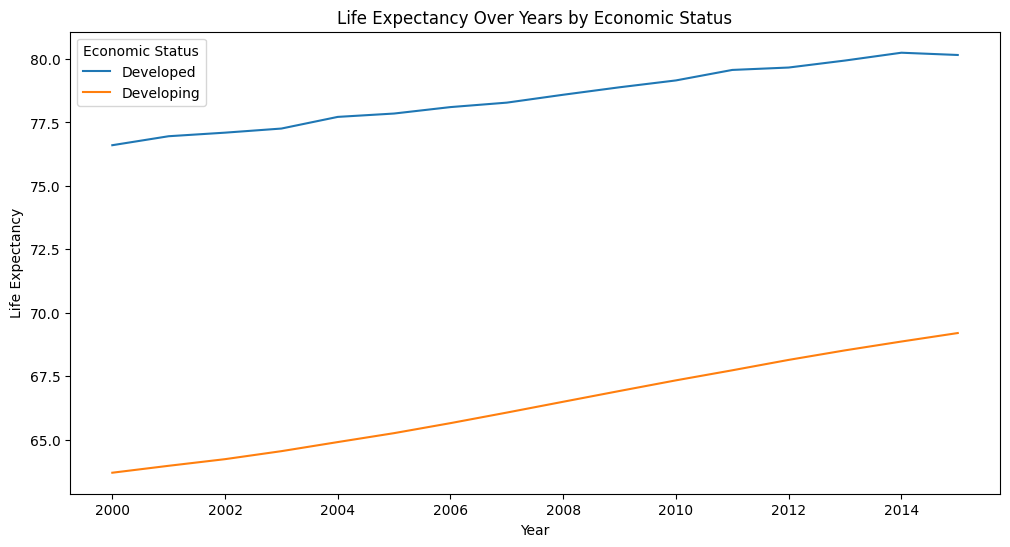

In [12]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Year', y='Life_expectancy', hue='Economic_Status_Developing', ci=None)
plt.title('Life Expectancy Over Years by Economic Status')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.legend(title='Economic Status', labels=['Developed', 'Developing'])
plt.show()

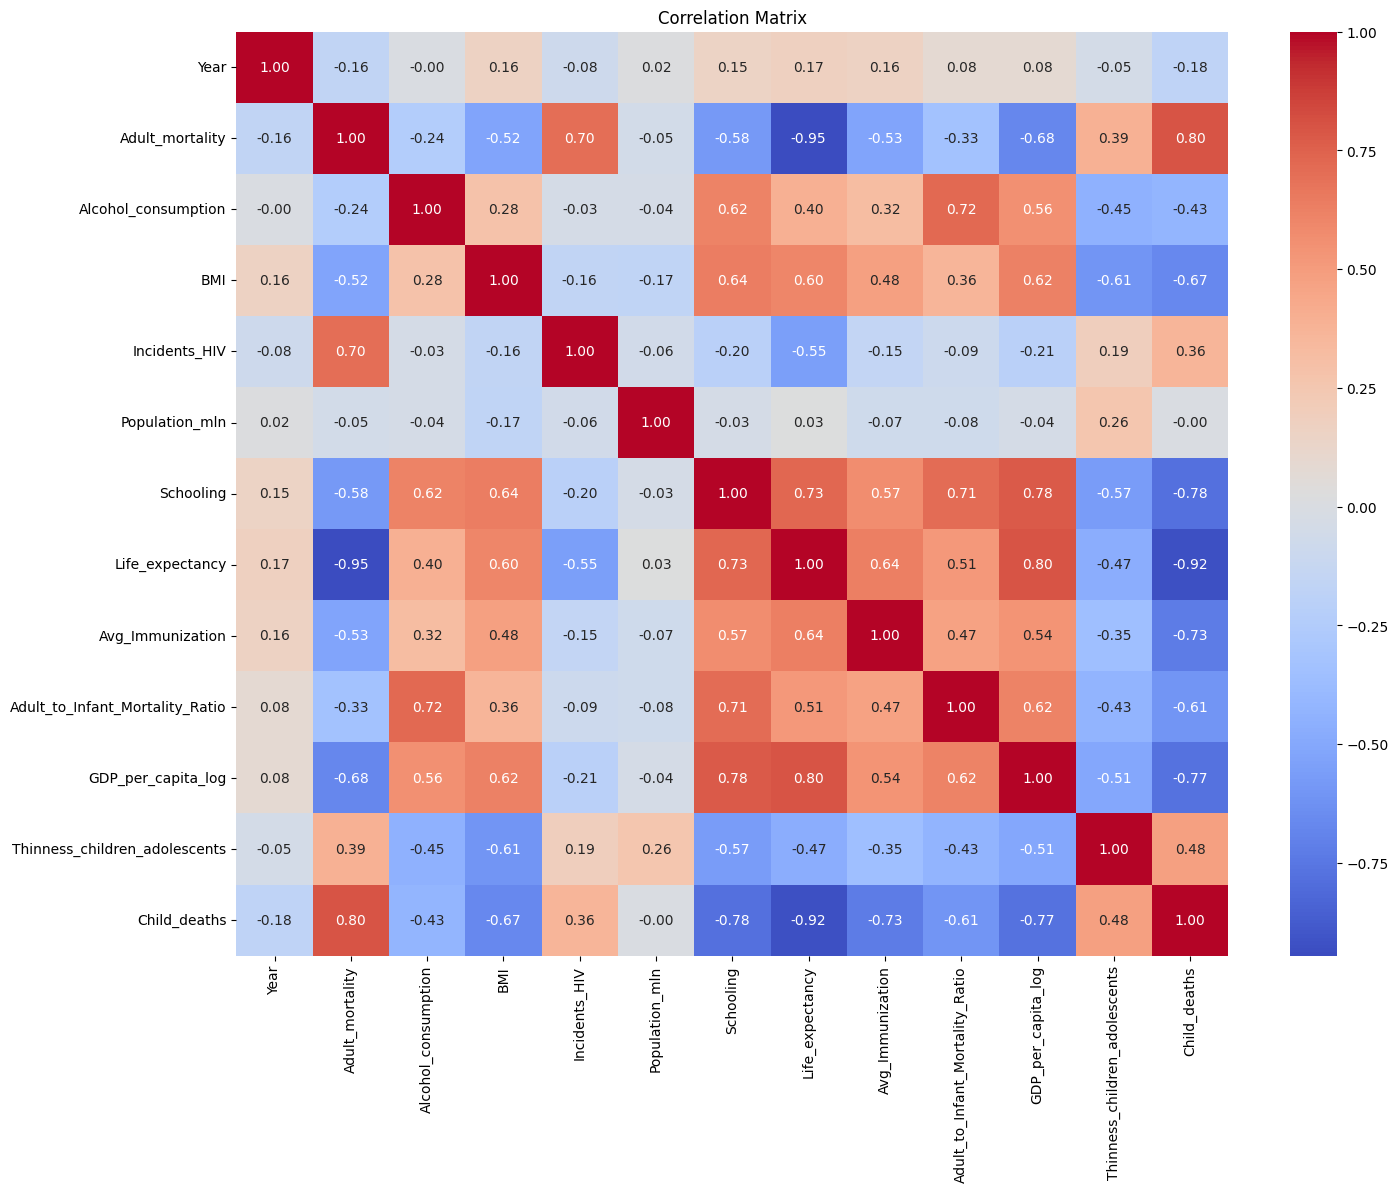

In [13]:
plt.figure(figsize=(16,12))
numeric_df = df.select_dtypes(include=[np.number]) 
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

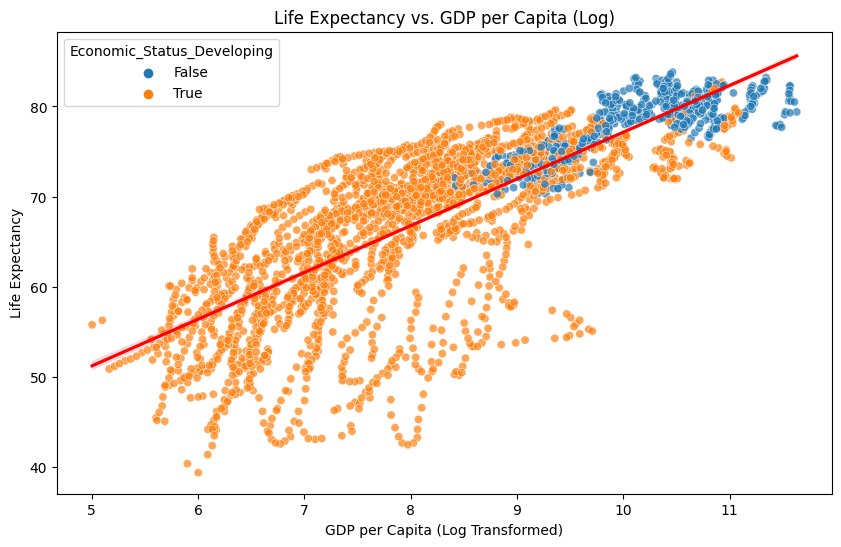

In [14]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='GDP_per_capita_log', y='Life_expectancy', hue='Economic_Status_Developing', alpha=0.7)
sns.regplot(data=df, x='GDP_per_capita_log', y='Life_expectancy', scatter=False, color='red')
plt.title('Life Expectancy vs. GDP per Capita (Log)')
plt.xlabel('GDP per Capita (Log Transformed)')
plt.ylabel('Life Expectancy')
plt.show()

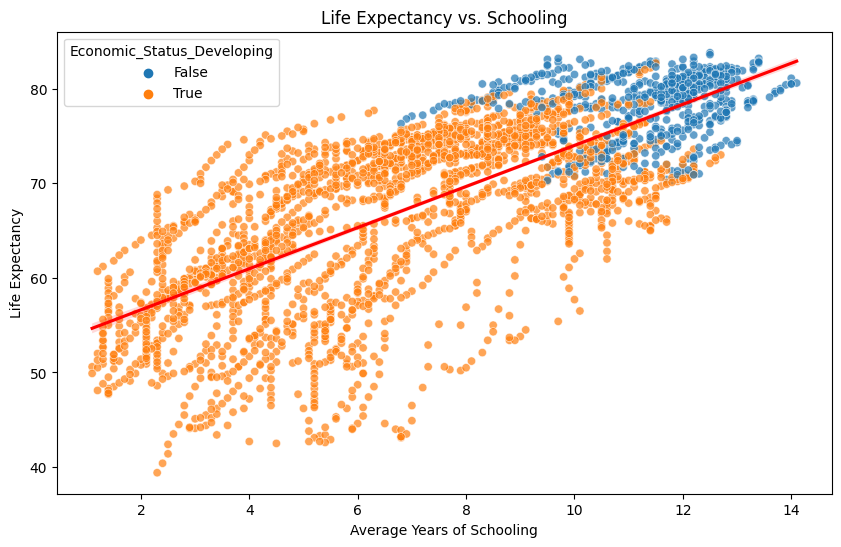

In [15]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Schooling', y='Life_expectancy', hue='Economic_Status_Developing', alpha=0.7)
sns.regplot(data=df, x='Schooling', y='Life_expectancy', scatter=False, color='red')
plt.title('Life Expectancy vs. Schooling')
plt.xlabel('Average Years of Schooling')
plt.ylabel('Life Expectancy')
plt.show()

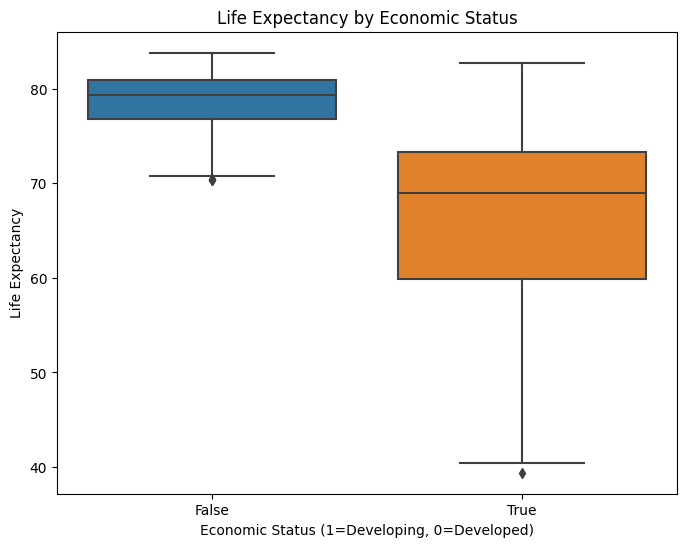

In [16]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Economic_Status_Developing', y='Life_expectancy', data=df)
plt.title('Life Expectancy by Economic Status')
plt.xlabel('Economic Status (1=Developing, 0=Developed)')
plt.ylabel('Life Expectancy')
plt.show()

c:\Users\sabme\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


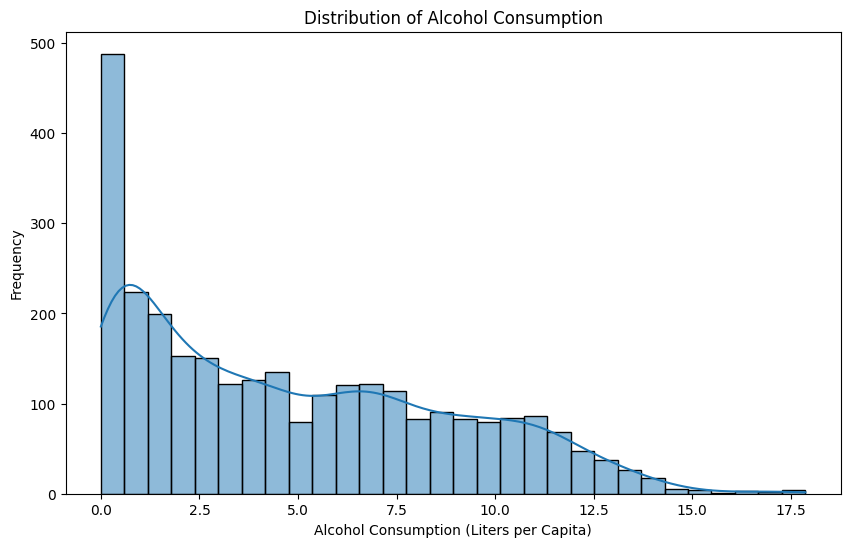

In [17]:
plt.figure(figsize=(10,6))
sns.histplot(df['Alcohol_consumption'], bins=30, kde=True)
plt.title('Distribution of Alcohol Consumption')
plt.xlabel('Alcohol Consumption (Liters per Capita)')
plt.ylabel('Frequency')
plt.show()

c:\Users\sabme\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


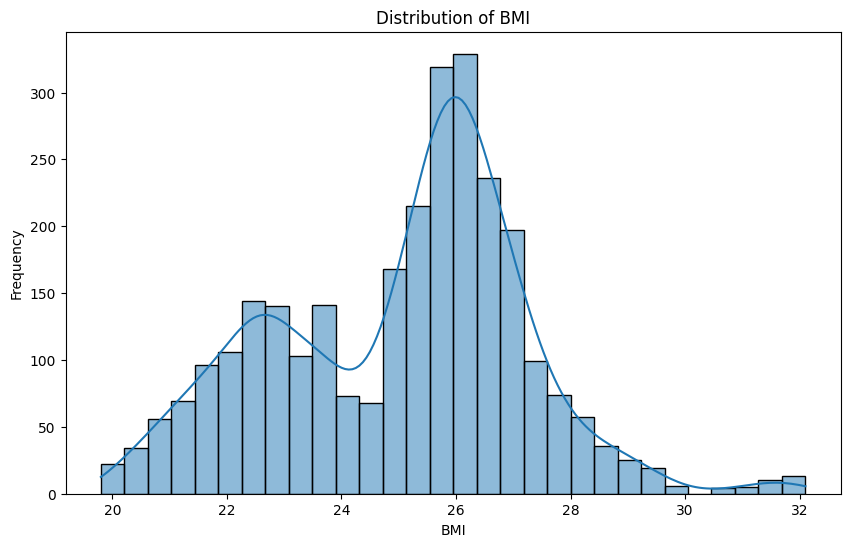

In [18]:
plt.figure(figsize=(10,6))
sns.histplot(df['BMI'], bins=30, kde=True)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

c:\Users\sabme\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sabme\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sabme\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sabme\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

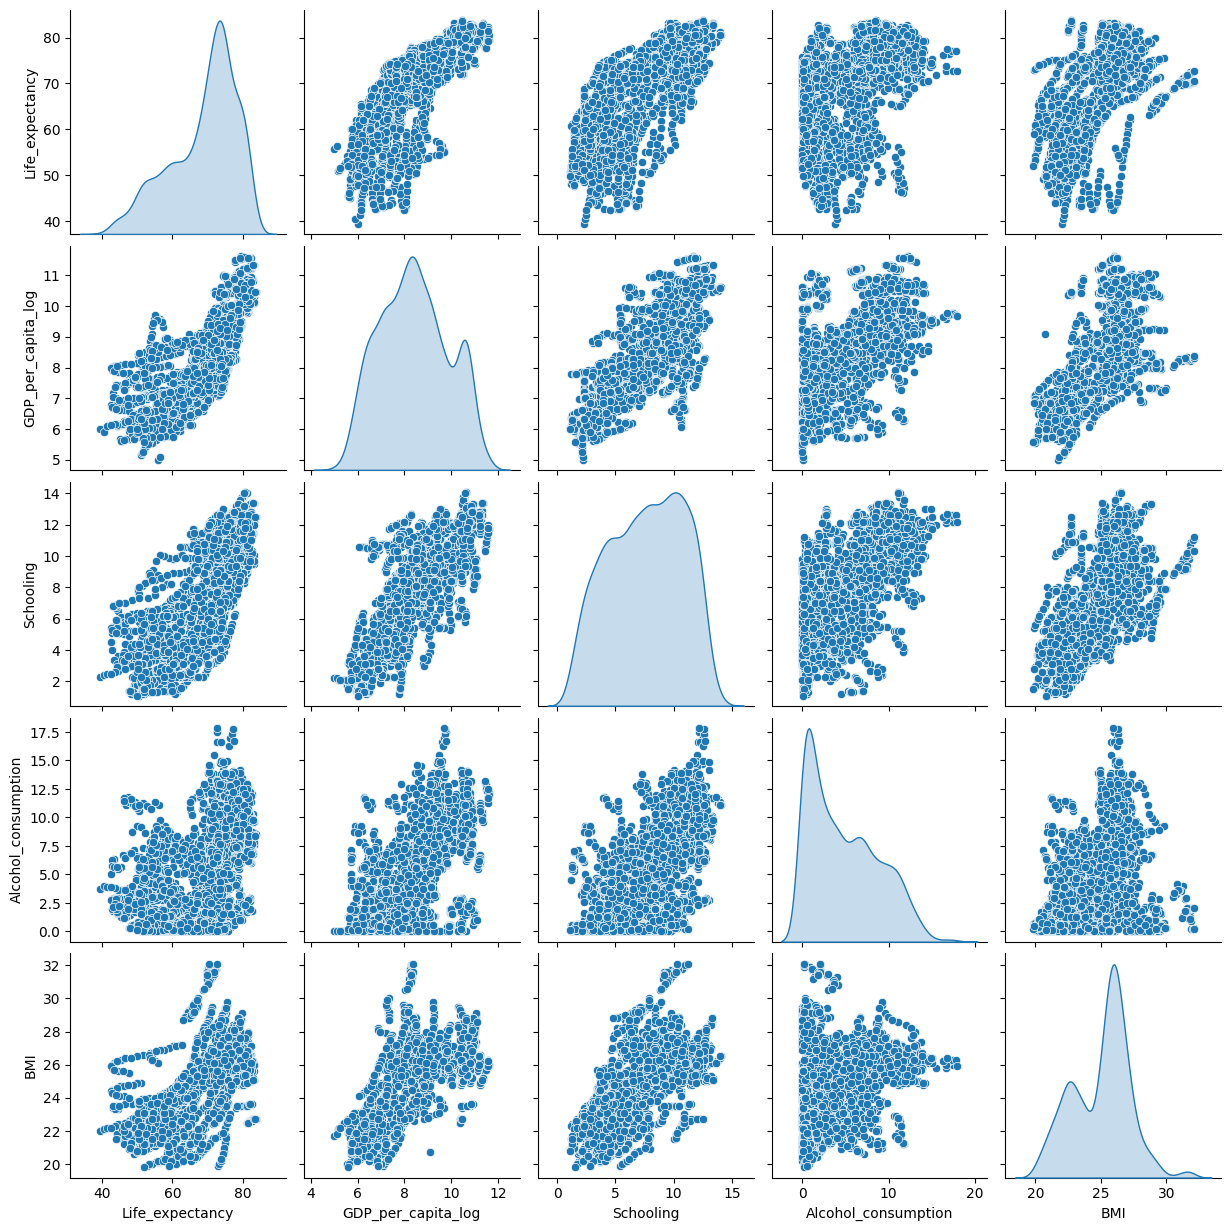

In [19]:
subset = df[['Life_expectancy', 'GDP_per_capita_log', 'Schooling', 'Alcohol_consumption', 'BMI']]
sns.pairplot(subset, diag_kind='kde')
plt.show()

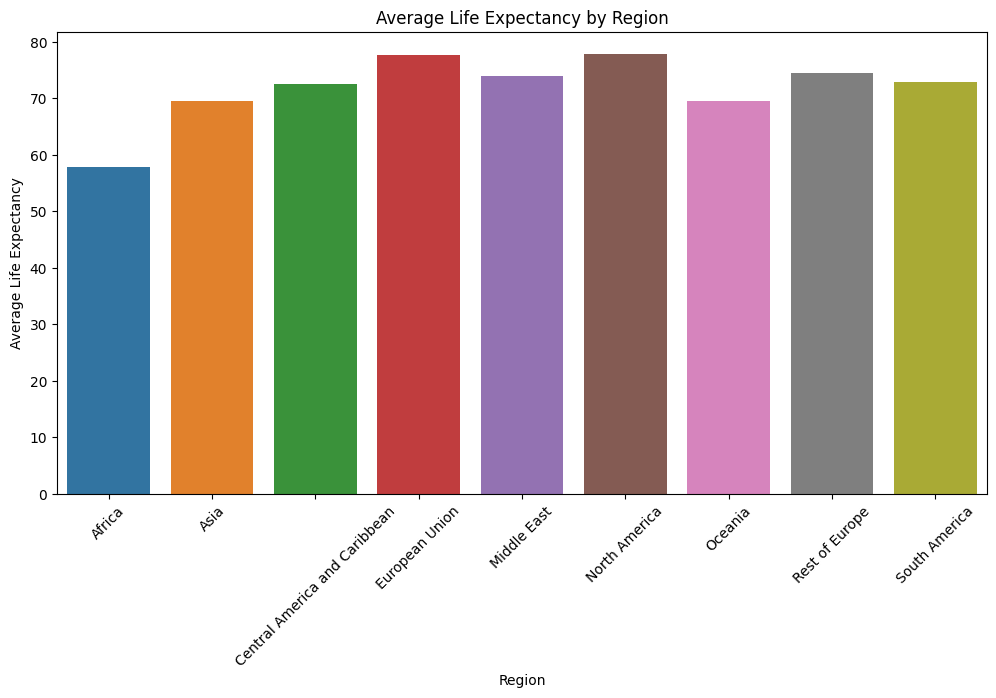

In [20]:
plt.figure(figsize=(12,6))
region_life_expectancy = df.groupby('Region')['Life_expectancy'].mean().reset_index()
sns.barplot(data=region_life_expectancy, x='Region', y='Life_expectancy')
plt.xticks(rotation=45)
plt.title('Average Life Expectancy by Region')
plt.xlabel('Region')
plt.ylabel('Average Life Expectancy')
plt.show()

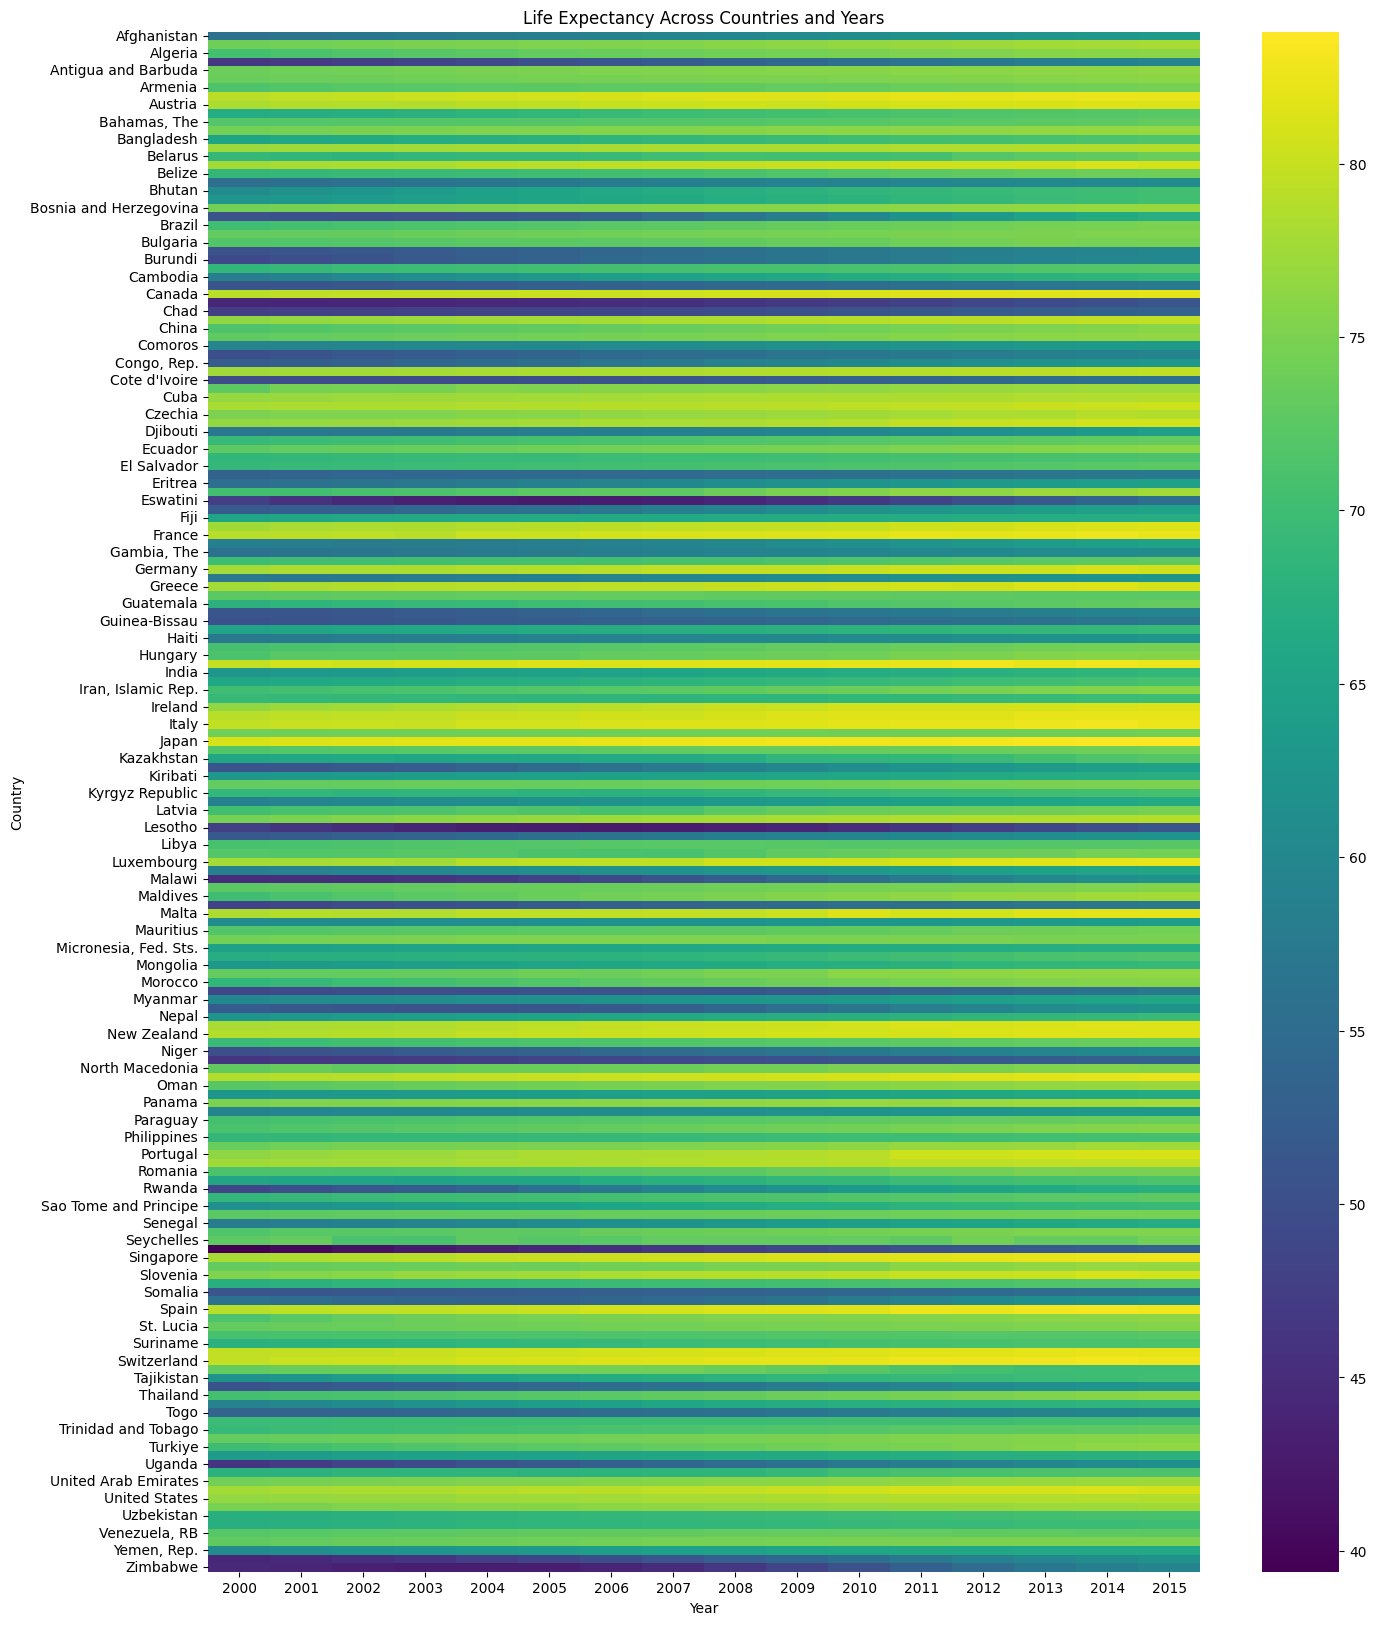

In [21]:
# Pivot the data
pivot_table = df.pivot_table(values='Life_expectancy', index='Country', columns='Year')

# Create the heatmap
plt.figure(figsize=(16,20))
sns.heatmap(pivot_table, cmap='viridis')
plt.title('Life Expectancy Across Countries and Years')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()

## Machine Learning Analysis

### Data Preparation

In [22]:
# Define target and features
X = df.drop(['Life_expectancy', 'Country', 'Region'], axis=1)
y = df['Life_expectancy']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Regression Models

#### Multiple Linear Regression

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [42]:
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr.coef_
})

# Sort coefficients by absolute value
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

print(coefficients[['Feature', 'Coefficient']])

                            Feature  Coefficient
12       Economic_Status_Developing    -0.873568
9                GDP_per_capita_log     0.519760
3                               BMI    -0.206184
6                         Schooling     0.093267
11                     Child_deaths    -0.050934
2               Alcohol_consumption     0.050277
4                     Incidents_HIV     0.048242
1                   Adult_mortality    -0.046538
10    Thinness_children_adolescents    -0.040517
0                              Year     0.025723
8   Adult_to_Infant_Mortality_Ratio    -0.019084
7                  Avg_Immunization    -0.002832
5                    Population_mln    -0.000187


#### Model Evaluation

In [26]:
y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print('Linear Regression RMSE:', rmse)
print('Linear Regression R^2:', r2)

Linear Regression RMSE: 1.3521072298268337
Linear Regression R^2: 0.9779712321699875


#### Ridge Regression

In [28]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

Ridge()

#### Lasso Regression

In [30]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [ ]:
# Ridge
y_pred_ridge = ridge.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)
print('Ridge Regression RMSE:', rmse_ridge)
print('Ridge Regression R^2:', r2_ridge)

# Lasso
y_pred_lasso = lasso.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)
print('Lasso Regression RMSE:', rmse_lasso)
print('Lasso Regression R^2:', r2_lasso)

Ridge Regression RMSE: 1.3520529962255086
Ridge Regression R^2: 0.9779729993012118
Lasso Regression RMSE: 1.369278234922491
Lasso Regression R^2: 0.9774081734176151
[73.05573683 79.78799424 64.55365011 55.74365464 78.48729594 79.65337915
 79.77577422 60.71981575 71.79542065 80.61903371 63.9166598  69.42992557
 81.22974707 74.65698313 74.94664748 56.0964146  73.94635891 80.08489655
 77.32695078 74.42654258 79.31181362 58.3307705  72.12232058 79.18061254
 76.54485372 66.2216151  75.55671957 68.94699548 56.34663002 58.52698239
 61.41058528 75.84151724 76.82341162 47.42457956 59.99008144 71.27593742
 62.65662884 76.40846232 51.88332399 59.30776131 73.07526248 69.88991867
 57.40951446 63.99433249 73.07850337 66.96823905 49.77795212 57.16965102
 79.85309236 70.7033539  68.80518927 73.57590816 74.70657972 76.88816485
 79.03496073 72.29751437 63.19677367 73.28244138 70.76472738 63.25388199
 71.50319118 69.32867006 62.51831883 76.87568272 75.43106864 79.0482986
 80.27917638 79.96632031 68.81276

### Classification Models

#### Logistic Regression

In [33]:
# Prepare data
X_cls = df.drop(['Economic_Status_Developing', 'Country', 'Region'], axis=1)
y_cls = df['Economic_Status_Developing']

# Split data
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

# Model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_cls, y_train_cls)

c:\Users\sabme\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

#### Evaluation

In [35]:
y_pred_cls = logreg.predict(X_test_cls)
print(classification_report(y_test_cls, y_pred_cls))

              precision    recall  f1-score   support

       False       0.93      0.91      0.92       118
        True       0.98      0.98      0.98       455

    accuracy                           0.97       573
   macro avg       0.95      0.94      0.95       573
weighted avg       0.97      0.97      0.97       573



#### Random Forest Classifier

In [37]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_cls, y_train_cls)

RandomForestClassifier(random_state=42)

In [43]:
# Get the feature importances
importances = rf.feature_importances_

# Get the feature names
feature_names = X_train_cls.columns

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame in descending order of importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importances)

                            Feature  Importance
12                     Child_deaths    0.202899
7                   Life_expectancy    0.168603
9   Adult_to_Infant_Mortality_Ratio    0.136292
10               GDP_per_capita_log    0.124858
2               Alcohol_consumption    0.103937
11    Thinness_children_adolescents    0.083932
6                         Schooling    0.068589
1                   Adult_mortality    0.034489
4                     Incidents_HIV    0.029204
5                    Population_mln    0.017168
3                               BMI    0.013861
8                  Avg_Immunization    0.010134
0                              Year    0.006034


#### Evaluation

In [38]:
y_pred_rf = rf.predict(X_test_cls)
print(classification_report(y_test_cls, y_pred_rf))

              precision    recall  f1-score   support

       False       1.00      0.99      1.00       118
        True       1.00      1.00      1.00       455

    accuracy                           1.00       573
   macro avg       1.00      1.00      1.00       573
weighted avg       1.00      1.00      1.00       573

